In [18]:
from scripts.presentation import Presenter
from os.path import join

# Contains aligned results (aligned + sentence split with bertalign)
results_folder = 'post_results'
p = Presenter(results_folder=results_folder, metrics=['BLEU', 'chrF'])

## Translator Correlations
* I.e., if DeepL has high BLEU score for a given pair, so does GPT4.1 and vice versa.

In [19]:
datasets = ['ep', 'flores', 'opus']
translators = ['deepl', 'gpt']

for d in datasets:
        key1 = f'{d}-deepl'
        key2 = f'{d}-gpt'
        p.show_correlations(
            key1=key1, key2=key2, metric1='BLEU', metric2='BLEU')

Keys: ep-deepl : ep-gpt
Metrics: BLEU : BLEU
Pearson correlation: 0.93 (p = 1.9e-48)
Spearman correlation: 0.93 (p = 2.0e-47)

Keys: flores-deepl : flores-gpt
Metrics: BLEU : BLEU
Pearson correlation: 0.96 (p = 2.0e-63)
Spearman correlation: 0.96 (p = 2.6e-59)

Keys: opus-deepl : opus-gpt
Metrics: BLEU : BLEU
Pearson correlation: 0.96 (p = 1.5e-11)
Spearman correlation: 0.94 (p = 9.8e-10)



## BLEU & chrF correlations
* If BLEU score is high, so is chrF

In [20]:
datasets = ['ep', 'flores', 'opus']
translators = ['deepl', 'gpt']

for d in datasets:
    for t in translators:
        key = f'{d}-{t}'
        p.show_correlations(key1=key, key2=key, metric1='BLEU', metric2='chrF')

Keys: ep-deepl : ep-deepl
Metrics: BLEU : chrF
Pearson correlation: 0.83 (p = 1.3e-29)
Spearman correlation: 0.83 (p = 3.1e-29)

Keys: ep-gpt : ep-gpt
Metrics: BLEU : chrF
Pearson correlation: 0.87 (p = 1.6e-34)
Spearman correlation: 0.89 (p = 3.1e-39)

Keys: flores-deepl : flores-deepl
Metrics: BLEU : chrF
Pearson correlation: 0.94 (p = 5.5e-53)
Spearman correlation: 0.92 (p = 4.5e-46)

Keys: flores-gpt : flores-gpt
Metrics: BLEU : chrF
Pearson correlation: 0.95 (p = 8.5e-55)
Spearman correlation: 0.93 (p = 4.7e-49)

Keys: opus-deepl : opus-deepl
Metrics: BLEU : chrF
Pearson correlation: 0.85 (p = 2.2e-06)
Spearman correlation: 0.87 (p = 8.0e-07)

Keys: opus-gpt : opus-gpt
Metrics: BLEU : chrF
Pearson correlation: 0.88 (p = 4.1e-07)
Spearman correlation: 0.87 (p = 4.9e-07)



### Plotting
* We observe that the data from EuroParl - DeepL has the lowest BLEU-chrF correlation, we can inspect this visually using linear regression.

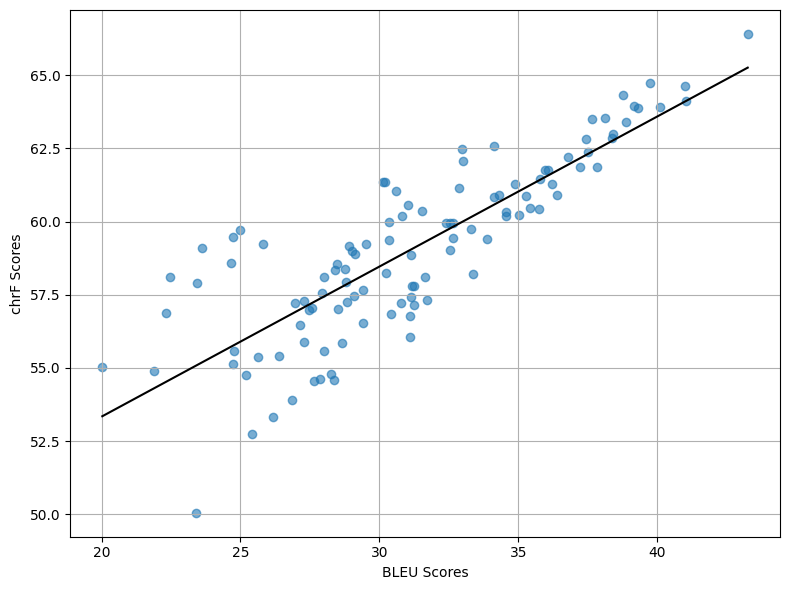

In [21]:
key = 'ep-deepl'
x_vals, y_vals, model, labels = p.prep_lin_reg_1(key1=key, key2=key, metric1='BLEU', metric2='chrF')
p.basic_linear_regression(x_vals, y_vals, x_label='BLEU Scores', y_label='chrF Scores', model=model)

In [22]:
outliers = p.analyse_residuals(x_vals=x_vals, y_vals=y_vals, model=model, top_n=20, labels=labels)

sv-fi 22.32, 56.87
es-de 32.98, 62.50
fr-el 27.63, 54.55
sv-el 27.85, 54.63
da-el 28.26, 54.79
el-de 30.21, 61.36
pt-fi 23.42, 57.89
fr-de 30.13, 61.37
de-fi 24.67, 58.59
da-fi 25.82, 59.23
de-el 26.85, 53.89
nl-es 31.11, 56.04
nl-pt 28.38, 54.58
it-el 26.17, 53.31
fi-el 25.41, 52.74
fr-fi 22.45, 58.09
en-fi 24.71, 59.46
es-fi 24.99, 59.71
el-fi 23.62, 59.11
nl-el 23.42, 50.05


In [23]:
from scripts.presentation import lang_freq
_ = lang_freq(outliers) # looks for the top 3 most frequent languages
for k, v in _.items():
    print(f'{k:<10}{v}')

to-fi     8
to-el     7
to-de     3
from-fr   3
from-nl   3
from-sv   2
from-es   2
from-da   2
from-el   2
from-de   2
from-pt   1
to-es     1
to-pt     1
from-it   1
from-fi   1
from-en   1


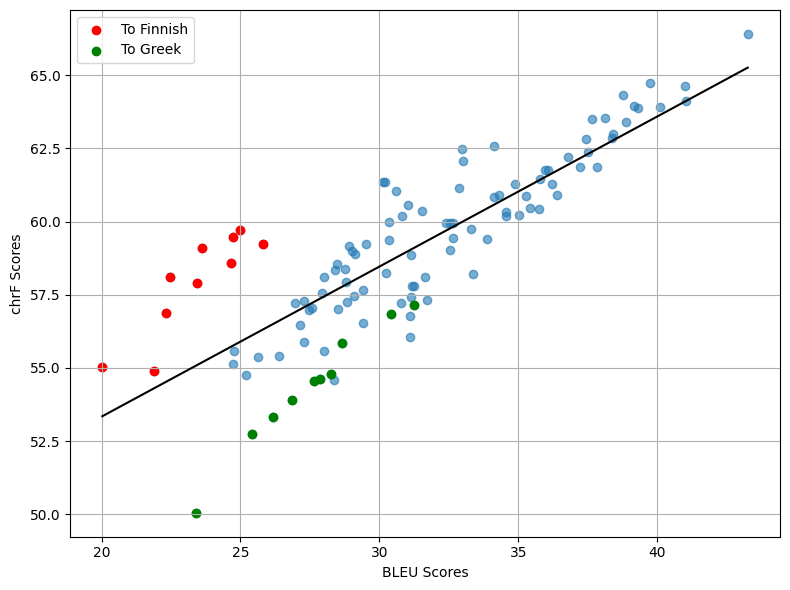

In [24]:
mark_func = p.mark_by_language_direction(labels=labels, x_vals=x_vals, y_vals=y_vals, to_langs=[('fi', 'red'), ('el', 'green')])
p.basic_linear_regression(x_vals=x_vals, y_vals=y_vals, x_label='BLEU Scores', y_label='chrF Scores',
                          model=model, mark_func=mark_func)

* We observe a similar pattern with the residuals for all cases:

ep-deepl


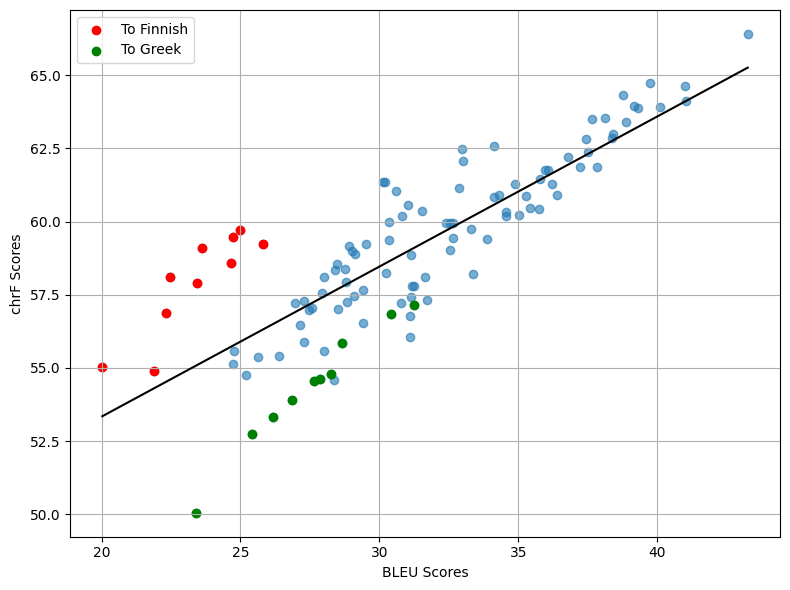

ep-gpt


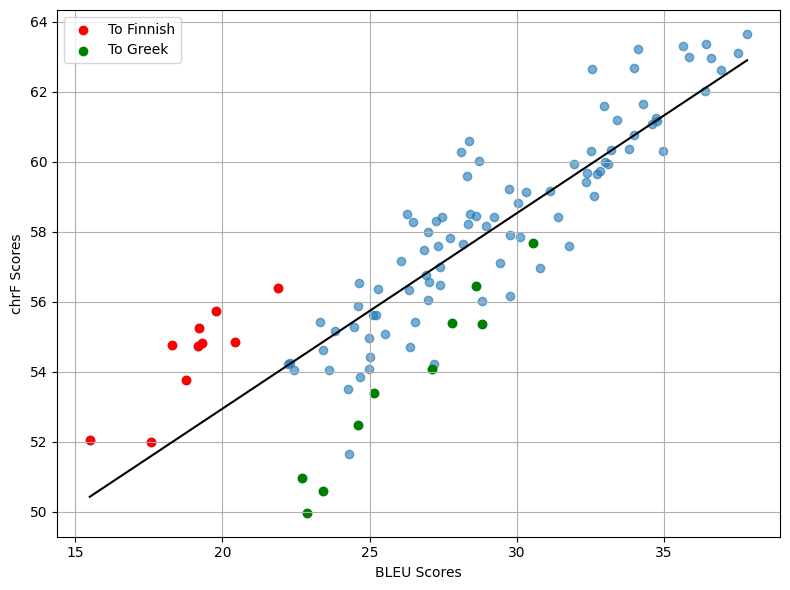

flores-deepl


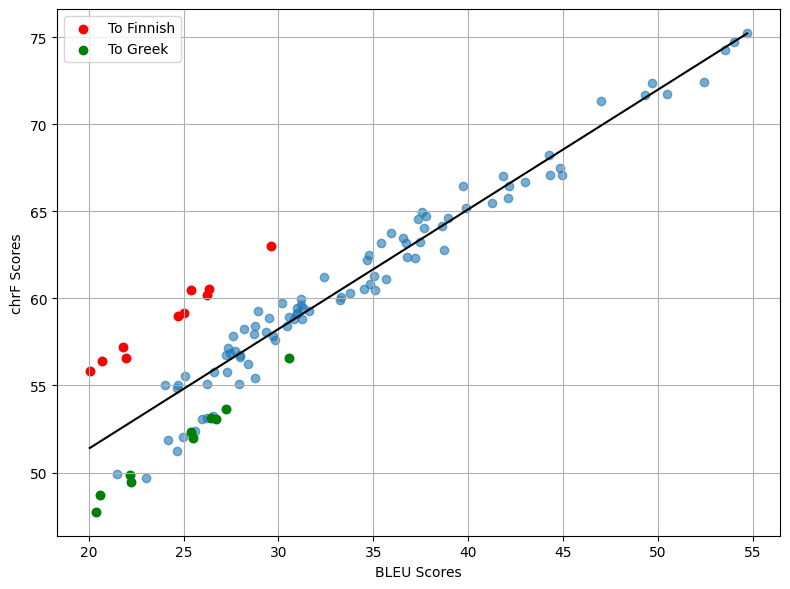

flores-gpt


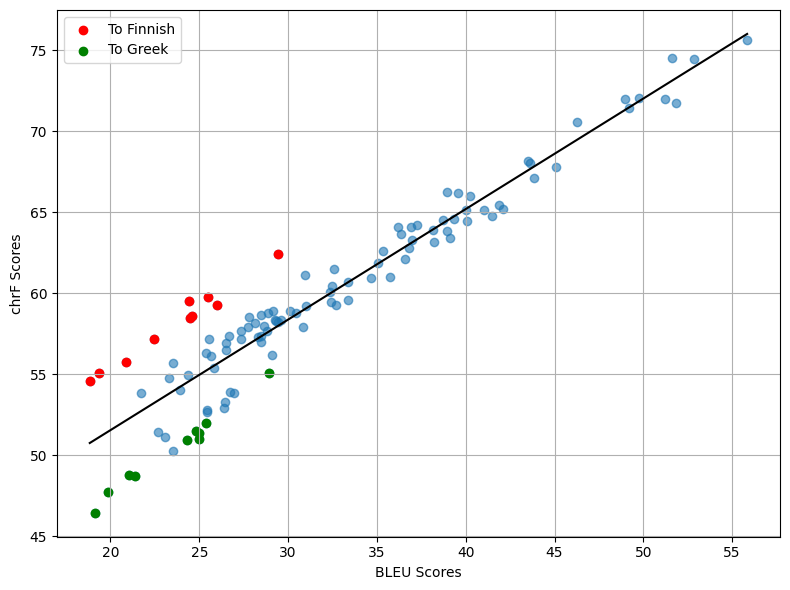

In [25]:
keys = ['ep-deepl', 'ep-gpt', 'flores-deepl', 'flores-gpt']
for key in keys:
    x_vals, y_vals, model, labels = p.prep_lin_reg_1(
        key1=key, key2=key, metric1='BLEU', metric2='chrF')
    
    mark_func = p.mark_by_language_direction(
        labels=labels, x_vals=x_vals, y_vals=y_vals, to_langs=[('fi', 'red'), ('el', 'green')])

    print(key)
    p.basic_linear_regression(
        x_vals, y_vals, x_label='BLEU Scores', y_label='chrF Scores', model=model, mark_func=mark_func)

## Matrices

ep-deepl


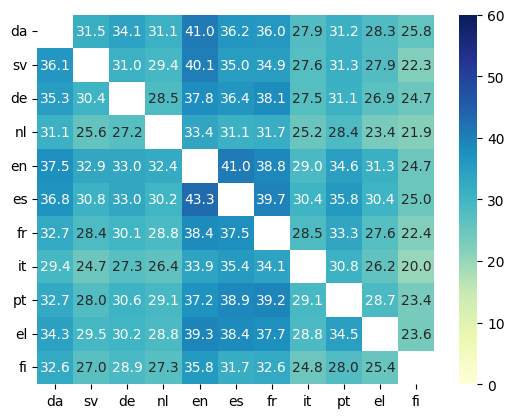


ep-gpt


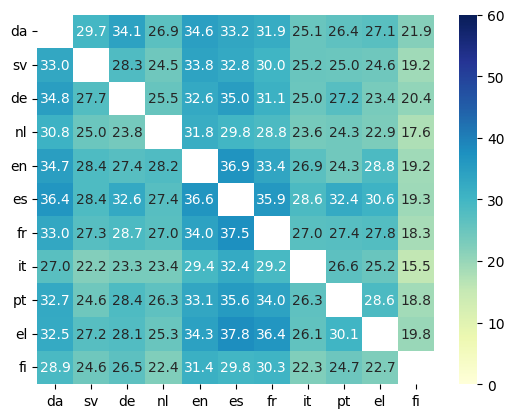


flores-deepl


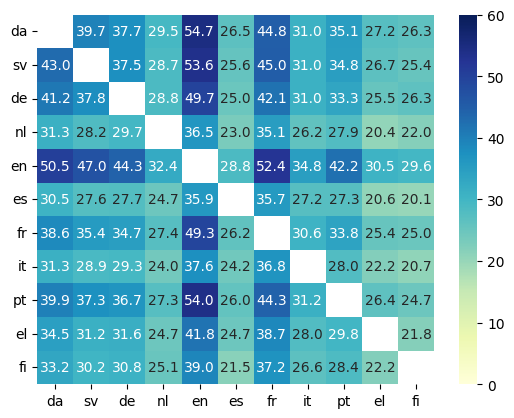


flores-gpt


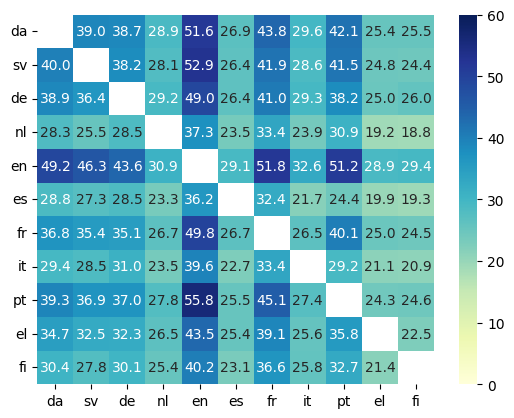


opus-deepl


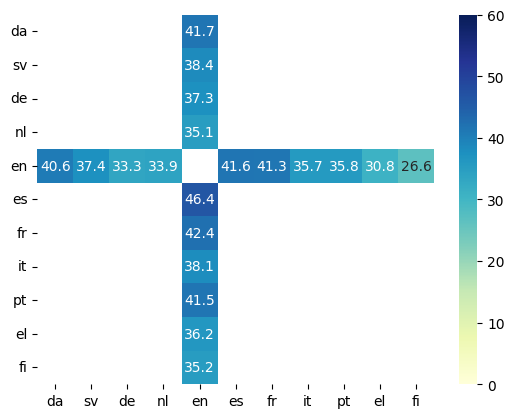


opus-gpt


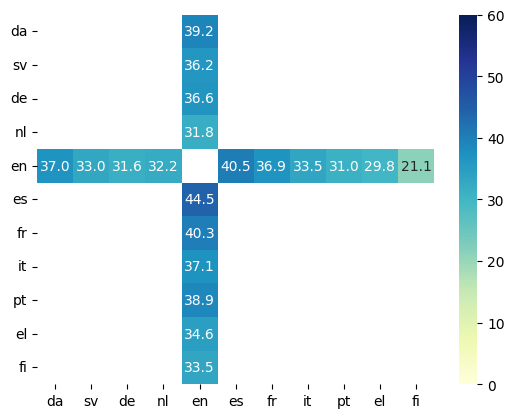

In [26]:
p.show_score_matrices(metric='BLEU')

ep-deepl


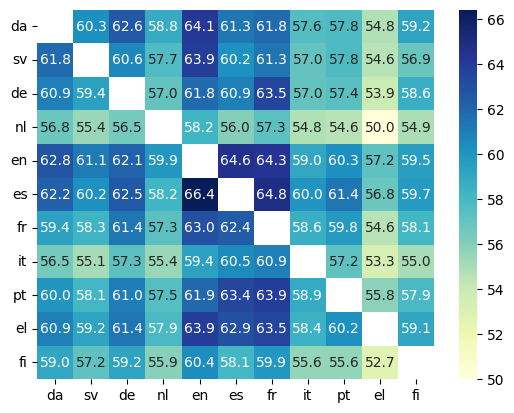


ep-gpt


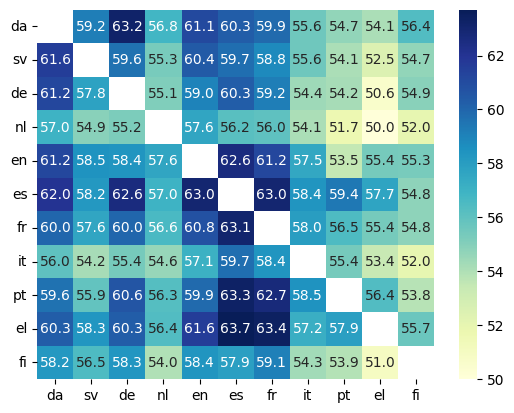


flores-deepl


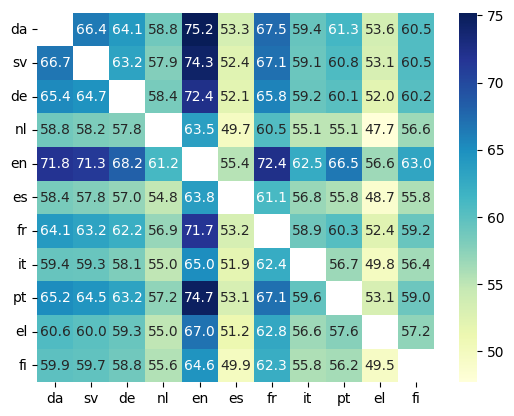


flores-gpt


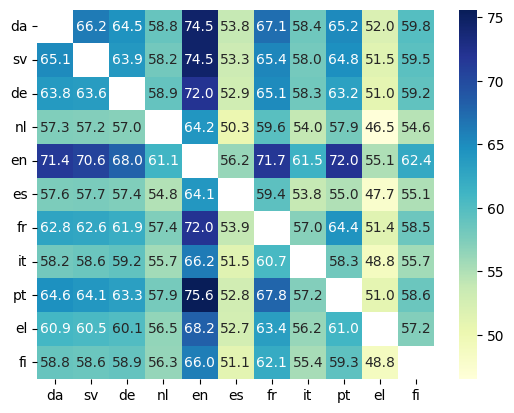


opus-deepl


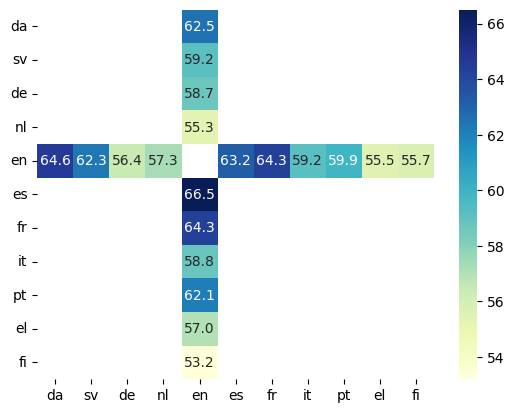


opus-gpt


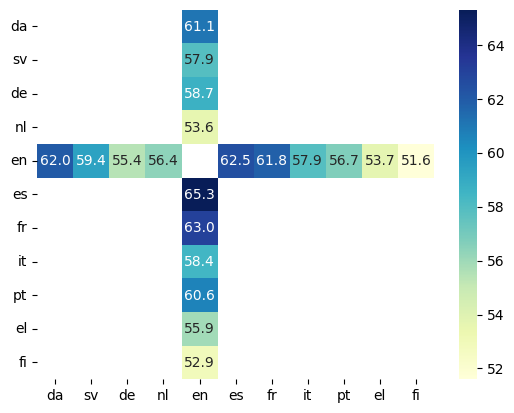

In [27]:
p.show_score_matrices(metric='chrF')

* The Romantic languages, at least in EuroParl have higher scores
* Both chrF and BLEU show a drop in quality for Spanish when going from EuroParl to Flores+
* While for BLEU, Finnish is lowest, for chrF, Greek is lowest. Shows the differences between the metrics.

## Aggregations

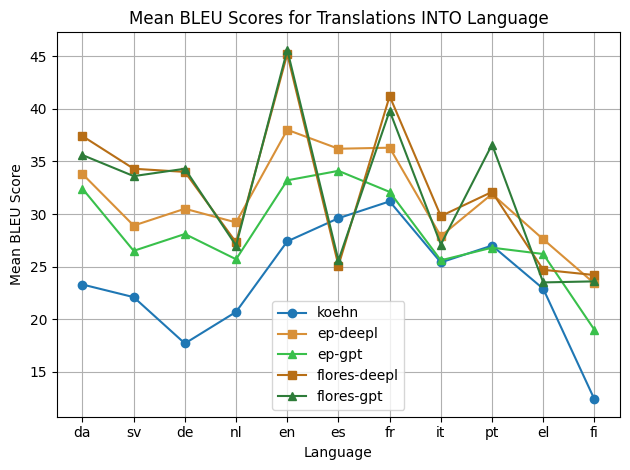

In [28]:
_ = p.bleu_from_into_lang(into=True, plot=True)

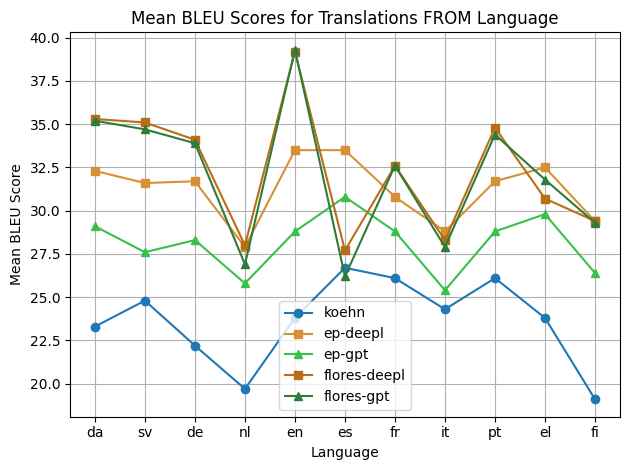

In [29]:
_ = p.bleu_from_into_lang(into=False, plot=True)

* We observe an overall improvement in translation quality as we compare SMT used by Koehn with DeepL and GPT
* The quality seems to depend on the dataset as well, with Flores+ having higher scores (more or less)
* We observe also general tendencies, such as higher quality for romantic languages, these tendencies, at least for EuroParl, were more or less preserved.

## Comet & BERT-F1

In [30]:
from scripts.presentation import Presenter
from os.path import join

# Contains aligned results (aligned + sentence split with bertalign)
results_folder = 'bert_comet'
p = Presenter(results_folder=results_folder, metrics=['BLEU', 'chrF', 'BERT-F1', 'COMET'])

In [31]:
keys = ['ep-deepl', 'ep-gpt']
for key in keys:
    p.show_correlations(key1=key, key2=key, metric1='BLEU', metric2='COMET')

Keys: ep-deepl : ep-deepl
Metrics: BLEU : COMET
Pearson correlation: -0.41 (p = 8.5e-06)
Spearman correlation: -0.34 (p = 2.3e-04)

Keys: ep-gpt : ep-gpt
Metrics: BLEU : COMET
Pearson correlation: -0.35 (p = 2.2e-04)
Spearman correlation: -0.25 (p = 8.5e-03)



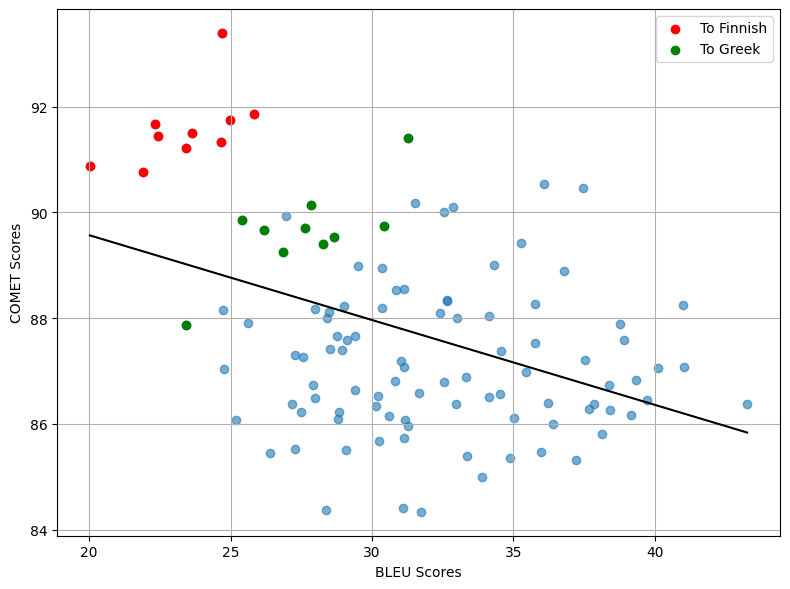

In [32]:
key = 'ep-deepl'
x_vals, y_vals, model, labels = p.prep_lin_reg_1(
    key1=key, key2=key, metric1='BLEU', metric2='COMET')
mark_func = p.mark_by_language_direction(
    labels=labels, x_vals=x_vals, y_vals=y_vals, to_langs=[('fi', 'red'), ('el', 'green')])

p.basic_linear_regression(
    x_vals, y_vals, x_label='BLEU Scores', y_label='COMET Scores', model=model, mark_func=mark_func)

## Comparing Translators & Datasets
* We can look at the correlation between translators and mark the datasets to see if there are differences

In [35]:
results_folder = 'post_results'
p = Presenter(results_folder=results_folder, metrics=['BLEU', 'chrF'])

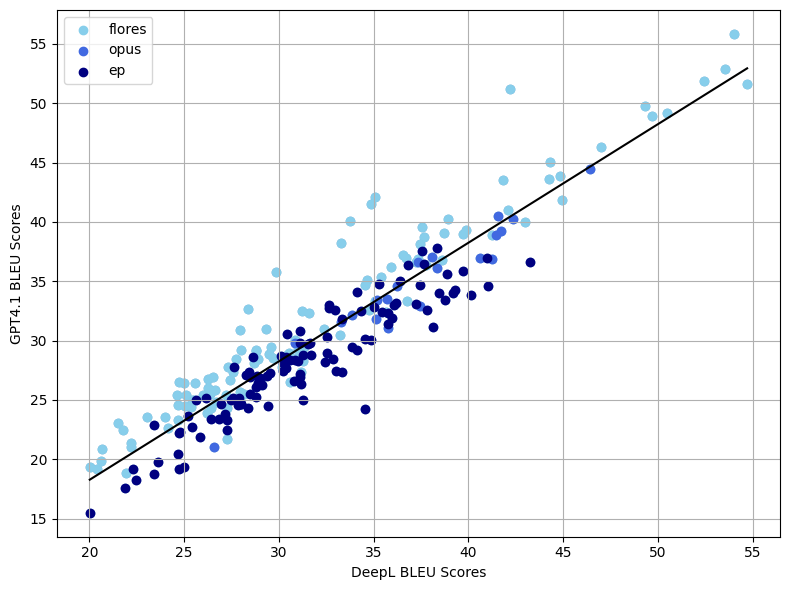

In [36]:
x_vals, y_vals, model, labels, mf = p.prep_lin_reg_2(
    metric1='BLEU', metric2='BLEU')
p.basic_linear_regression(x_vals, y_vals, x_label='DeepL BLEU Scores',
                          y_label='GPT4.1 BLEU Scores', model=model, mark_func=mf)

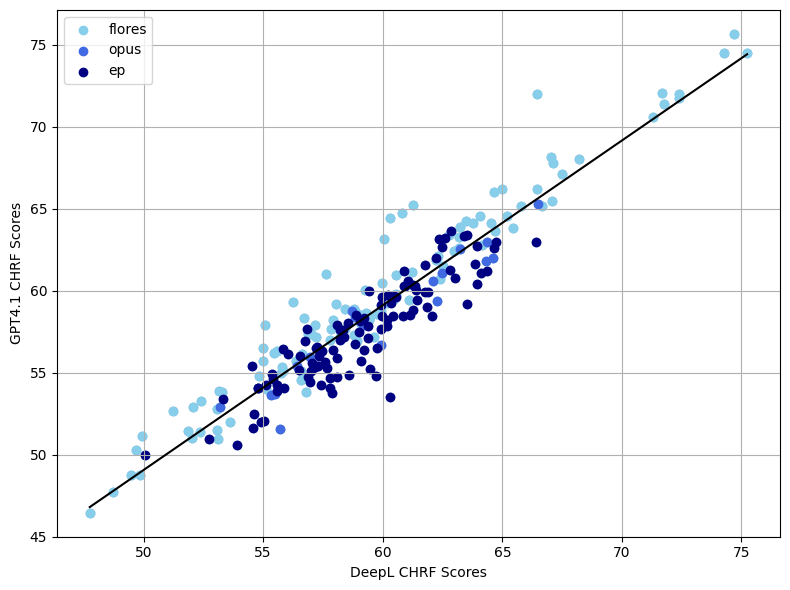

In [37]:
x_vals, y_vals, model, labels, mf = p.prep_lin_reg_2(
    metric1='chrF', metric2='chrF')
p.basic_linear_regression(x_vals, y_vals, x_label='DeepL CHRF Scores',
                          y_label='GPT4.1 CHRF Scores', model=model, mark_func=mf)